<a href="https://colab.research.google.com/github/msivakumar47/SIVAKUMAR-M/blob/main/k_means_project8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Running K-Means for K = 2
Silhouette Score = 0.6894


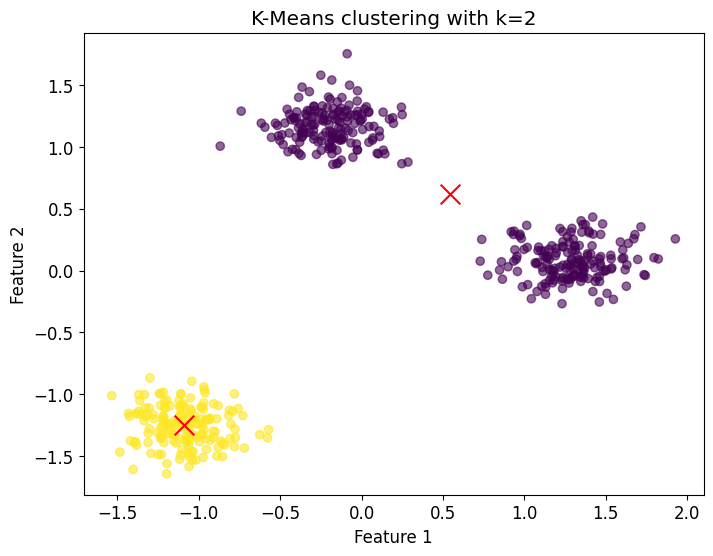


Running K-Means for K = 3
Silhouette Score = 0.8448


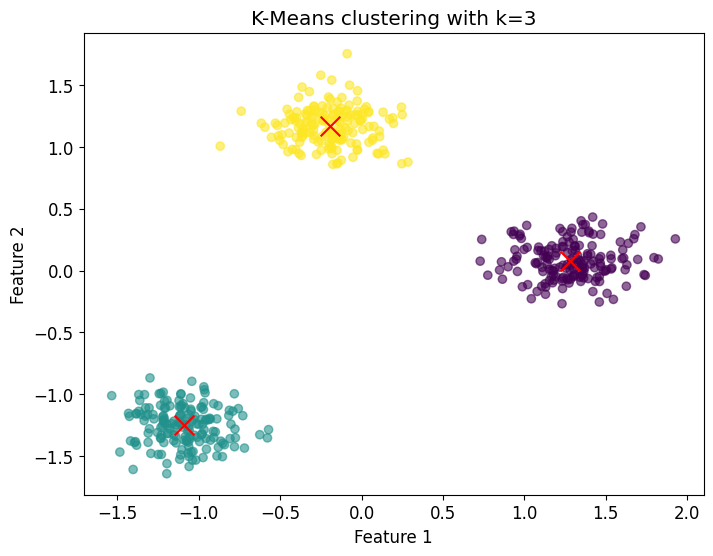


Running K-Means for K = 4
Silhouette Score = 0.6855


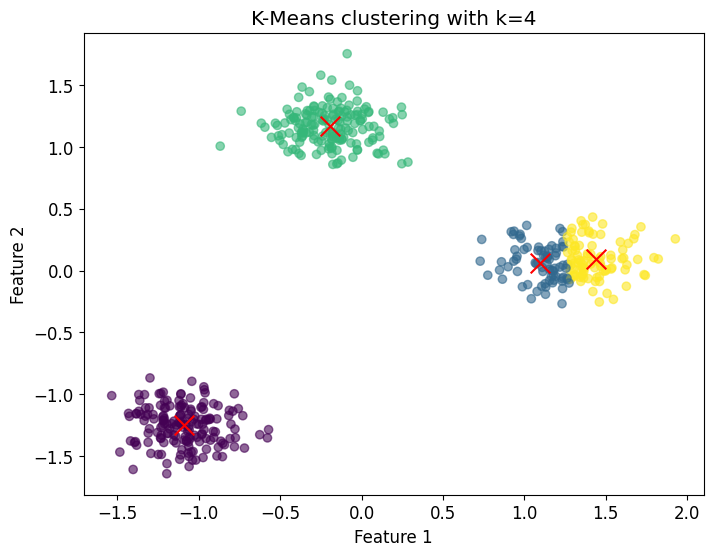

In [52]:
import numpy as np

class KMeansNumpy:
    def __init__(self, k, max_iter=100, n_init=10):
        self.k = k
        self.max_iter = max_iter
        self.n_init = n_init
        self.centroids = None

    def _kmeans_plus_plus_init(self, X):
        n_samples, _ = X.shape
        centroids = np.empty((self.k, X.shape[1]), dtype=X.dtype)

        # Choose first centroid randomly
        centroids[0] = X[np.random.randint(n_samples)]

        # Compute rest of the centroids
        for i in range(1, self.k):
            dist_sq = np.min(np.square(np.linalg.norm(X[:, np.newaxis] - centroids[:i], axis=2)), axis=1)
            prob = dist_sq / np.sum(dist_sq)
            cumulative_prob = np.cumsum(prob)
            r = np.random.rand()
            index = np.searchsorted(cumulative_prob, r)
            centroids[i] = X[index]
        return centroids

    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros_like(self.centroids)
        for i in range(self.k):
            points = X[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]  # retain old centroid if cluster is empty
        return new_centroids

    def fit(self, X):
        best_inertia = np.inf
        best_labels = None
        best_centroids = None

        for _ in range(self.n_init):
            self.centroids = self._kmeans_plus_plus_init(X)

            for _ in range(self.max_iter):
                labels = self._assign_clusters(X, self.centroids)
                new_centroids = self._update_centroids(X, labels)
                if np.allclose(self.centroids, new_centroids):
                    break
                self.centroids = new_centroids

            inertia = np.sum((np.linalg.norm(X - self.centroids[labels], axis=1)) ** 2)
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = self.centroids.copy()

        self.centroids = best_centroids
        return best_labels, self.centroids

def silhouette_score_manual(X, labels):
    n = X.shape[0]
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
        return -1  # silhouette score undefined for 1 cluster

    a = np.zeros(n)
    b = np.full(n, np.inf)
    for i in range(n):
        same_cluster = (labels == labels[i])
        other_clusters = (labels != labels[i])

        if np.sum(same_cluster) > 1:
            a[i] = np.mean(np.linalg.norm(X[i] - X[same_cluster], axis=1))
        else:
            a[i] = 0

        for label in unique_labels:
            if label != labels[i]:
                cluster_points = X[labels == label]
                dist_to_cluster = np.mean(np.linalg.norm(X[i] - cluster_points, axis=1))
                if dist_to_cluster < b[i]:
                    b[i] = dist_to_cluster

    silhouette_vals = (b - a) / np.maximum(a, b)
    return np.mean(silhouette_vals)

def visualize_clusters(X, labels, centroids, k):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200)
    plt.title(f'K-Means clustering with k={k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    X, y = make_blobs(n_samples=500, centers=3, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in [2, 3, 4]:
        print(f"\nRunning K-Means for K = {k}")

        model = KMeansNumpy(k=k, max_iter=100, n_init=10)
        labels, centroids = model.fit(X_scaled)

        score = silhouette_score_manual(X_scaled, labels)
        print(f"Silhouette Score = {score:.4f}")

        visualize_clusters(X_scaled, labels, centroids, k)
